# Maximum Entropy Sampling

The code below provides a set of routines that implement that the algorithm of maximum entropy sampling in complex networks, as described in

F. Radicchi and C. Castellano, 
[Uncertainty reduction for stochastic processes on complex networks](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.198301), 
Phys. Rev. Lett. <strong>120</strong>, 198301  (2018)

The code below reproduces some of the results of the above-mentioned paper.
This code is released for illustrative purposes only. All results reported in the paper
have been generated using a C implementation of the algorithm that is much faster than this Python version. For questions, feel free to send an email to <filiradi@indiana.edu>.

Libraries required in the rest of the code

In [1]:
import networkx as nx
import random
import numpy as np
import heapq
import time


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from scipy.interpolate import interp1d


from datetime import datetime
random.seed(datetime.now())

## Independent Cascade (IC) model

Marginal and pairwise entropy of variables are computed using $T$ independent numerical simulations of the IC model. The model has a single parameter $p$ standing for the probability of spreading. Each numerical simulations is started frm a configuration where all nodes are in the susceptible state, except for a single randomly chosen seed in the infected state. We compute the probability of the miscropic configuration obtained at the end of the dynamics, when there are no longer infected nodes.

In [2]:
def single_simulation_ICM (G, p):
    
    state = {}
    active = []
    for n in G:
        state[n] = 0
    
    ##one random seed active
    n = random.choice(list(G.nodes()))
    state[n] = 1
    active.append(n)
    
    
    while len(active) > 0:
        
        tmp = []
        
        for i in range(0, len(active)):
            n = active[i]
            neigh = G.neighbors(n)
            for m in neigh:
                if state[m] == 0:
                    if random.random() < p:
                        state[m] = 1
                        tmp.append(m)
            state[n] = 2
            
        active = []
        active[:] = tmp[:]
        
    
        
    return state
            
    
def multiple_simulations_ICM (G, p, T):
    
    
    list_of_nodes = sorted(list(G.nodes()))
    
    joint_prob = {}
    marg_prob = {}
    for i in range(0, len(list_of_nodes)):
        n = list_of_nodes[i]
        marg_prob[n] = {}
    for i in range(0, len(list_of_nodes)-1):
        n = list_of_nodes[i]
        for j in range(i+1, len(list_of_nodes)):
            m = list_of_nodes[j]
            joint_prob[n,m] = {}
    
    
    results = {}
    for t in range(0, T):
        results[t] = single_simulation_ICM (G, p)

    for t in range(0, T):
        for i in range(0, len(list_of_nodes)):
            n = list_of_nodes[i]
            res = results[t][n]
            if res not in marg_prob[n]:
                marg_prob[n][res] = 0.0
            marg_prob[n][res] += 1.0 / float(T)
            
        for i in range(0, len(list_of_nodes)-1):
            n = list_of_nodes[i]
            for j in range(i+1, len(list_of_nodes)):
                m = list_of_nodes[j]
                res = str(results[t][n]) + ',' + str(results[t][m])
                if res not in joint_prob[n,m]:
                    joint_prob[n,m][res] = 0.0
                joint_prob[n,m][res] += 1.0 / float(T)
                
    
    
    marg_entropy = {} 
    cond_entropy = {}
    
    for n in marg_prob:
        marg_entropy[n] = 0.0
        for z in marg_prob[n]:
            tmp = marg_prob[n][z]
            if tmp > 0.0:
                marg_entropy[n] -= tmp * np.log2(tmp)
                
    for n,m in joint_prob:
        cond_entropy[n,m] = 0.0
        cond_entropy[m,n] = 0.0
        for z in joint_prob[n,m]:
            tmp = joint_prob[n,m][z]
            if tmp > 0.0:
                cond_entropy[n,m] -= tmp * np.log2(tmp)
                cond_entropy[m,n] -= tmp * np.log2(tmp)
        cond_entropy[n,m] -= marg_entropy[m]
        cond_entropy[m,n] -= marg_entropy[n]
        
    for i in range(0, len(list_of_nodes)):
        n = list_of_nodes[i]
        cond_entropy[n,n] = 0.0
    
    return marg_entropy, cond_entropy
            
        
    

## Maximum Entropy Sampling Algorithm
The code below implements the maximum entropy sampling algorith. It makes use of the submodularity of the entropy function to implement a lazy greedy search. A rooted tree in a potential node to sample is constructed using a Dijkstra-like algorithm. The main function returns two dictionaries with keys given by the labels of the nodes. One provides information on the rank of the nodes as they are added to the set of sampled nodes; the other dictionary provides information on the value of the joint entropy of the set of observed nodes when the node was included in the set of observed nodes. The main function returns also a list containing the ordered list of nodes that composed the set of observed nodes. The algorithm takes as inputs a graph and the dictionaries of the marginal and conditional pairwise entropy.

We provide also functions that construct the set of observed nodes using marginal entropy only, and randomly.

In [3]:
################################################################################## 
def compute_score_dijkstra (i, G, cond_entropy, observed, vector_observed):
    
    
    N = float(len(G))
    
    source = {}
    distance = {}
    visited = {}
    
    for n in G:
        distance[n] = N + 10
        source[n] = None
        
    distance[i] = 0.0
    source[i] = i
    
    
    
    ##heap##########
    heap_distance = []
    for n in G:
        tmp = distance[n]
        heapq.heappush(heap_distance, (tmp, n))
    ##################
    
     
    
    unvisited = {}
    vector_unvisited = {}
    for n in G:
        unvisited[n] = 1
        vector_unvisited[n] = -1
    
    
    while len(unvisited) > 0:
        
        
        control = -1
        while control < 0:
            tmp = heapq.heappop(heap_distance)
            current = tmp[1]
            dist_current = tmp[0]
            if vector_unvisited[current] < 0:
                control = 1
    
        

        vector_unvisited[current] = 1
        unvisited.pop(current, None)
        
                 
        neigh = G.neighbors(current)
        #random.shuffle(neigh)
        
        for m in neigh:
            
    
        
            if vector_unvisited[m] < 0:
                
                if vector_observed[m] > 0:
                    
                    if source[m] == None:
                        source[m] = source[current]
                        if vector_observed[current] > 0 or current == i:
                            source[m] = current
                        distance[m] = distance[current] + cond_entropy[m, source[m]]
                        
                    else:
                        if vector_observed[current] > 0 or current == i:
                            #delta = cond_entropy[m, current] - cond_entropy[m, source[m]]
                            delta = distance[current] + cond_entropy[m, current] - distance[m]
                            if delta < 0:
                                source[m] = current
                                distance[m] = distance[current] + cond_entropy[m, current]
                        else:
                            #delta = cond_entropy[m, source[current]] - cond_entropy[m, source[m]]
                            delta = distance[current] + cond_entropy[m, source[current]] - distance[m]
                            if delta < 0:
                                source[m] = source[current]
                                distance[m] = distance[current] + cond_entropy[m, source[m]]
            
                else:
                    source[m] = source[current]
                    if vector_observed[current] > 0 or current == i:
                        source[m] = current
                    distance[m] = distance[current]
                    
                
                heapq.heappush(heap_distance, (distance[m], m))
            
            
             
    score = 0.0
    for m in observed:
        score = score + cond_entropy[m, source[m]]
   
    
    return score
################################################################################## 



################################################################################## 
def lazy_find_dijkstra_tree (G, observed, vector_observed, heap_entropy, value_entropy,  marg_entropy, cond_entropy, old_entropy):
    
    ##lazy search
    tmp = heap_entropy[0]
    node_max = tmp[1]
    max_value = tmp[0]
      
    
    new_node_max = -1
    while new_node_max != node_max:
        
        node_max = new_node_max
        
        tmp = heapq.heappop(heap_entropy)
        new_node_max = tmp[1]
        new_max_value = tmp[0]
        
                   
        tmp_value = compute_score_dijkstra (new_node_max, G,  cond_entropy, observed, vector_observed)
        
        value_entropy[new_node_max] = tmp_value + marg_entropy[new_node_max] - old_entropy
        ##break ties
        value_entropy[new_node_max] += 1e-20 * (0.5 - random.random())
            
        tmp = (- value_entropy[new_node_max], new_node_max)
        heapq.heappush(heap_entropy, tmp)
        
        
    
    
    ##removal node
    node_max = new_node_max
    tmp = heapq.heappop(heap_entropy)
    node_max = tmp[1]
    max_value = tmp[0]
    
    
    
    value_entropy.pop(node_max, None)
    
    
    return node_max, - max_value


########################################################################


########################################################################

def max_ent_sampling (G, marg_entropy, cond_entropy):


    start_time = time.time()


    ##for lazy search
    heap_entropy = []
    value_entropy = {}
    for n in G:
        value_entropy[n] = marg_entropy[n]
        tmp = (- value_entropy[n], n)
        heapq.heappush(heap_entropy, tmp)
    ##

    
    
    N = len(G)
    total_observed = 0
    old_entropy = 0.0
    observed = {}
    vector_observed = {}
    list_observed = []
    for n in G:
        vector_observed[n] = -1
    rank = {}
    value = {}
    r = 1


    while total_observed < N:
    
        node, ent = lazy_find_dijkstra_tree (G, observed, vector_observed, heap_entropy, value_entropy,  marg_entropy, cond_entropy, old_entropy)
        old_entropy =  old_entropy + ent
        #print (node, ent, old_entropy)
        
        
        total_observed = total_observed + 1
        observed[node] = r
        vector_observed[node] = 1
        list_observed.append(node)
        rank[node] = r
        value[node] = old_entropy
        r = r + 1
    
  

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return rank, value, list_observed
########################################################################






def max_ent_sampling_ind_approx (G, marg_entropy, cond_entropy):


    start_time = time.time()


    ##for lazy search
    heap_entropy = []
    value_entropy = {}
    for n in G:
        value_entropy[n] = marg_entropy[n]
        tmp = (- value_entropy[n], n)
        heapq.heappush(heap_entropy, tmp)
    ##

    
    
    N = len(G)
    total_observed = 0
    old_entropy = 0.0
    observed = {}
    vector_observed = {}
    list_observed = []
    for n in G:
        vector_observed[n] = -1
    rank = {}
    value = {}
    r = 1


    while total_observed < N:
    
        
        tmp = heapq.heappop(heap_entropy)
        node = tmp[1]
        new_max_value = tmp[0]
        
        tmp_value = compute_score_dijkstra (node, G,  cond_entropy, observed, vector_observed)
        ent = tmp_value + marg_entropy[node] - old_entropy
        
        
        old_entropy =  old_entropy + ent
        #print (node, ent, old_entropy)
        
        
        total_observed = total_observed + 1
        observed[node] = r
        vector_observed[node] = 1
        list_observed.append(node)
        rank[node] = r
        value[node] = old_entropy
        r = r + 1
    
  

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return rank, value, list_observed
########################################################################



################################################################################## 


########################################################################

def random_sampling (G, marg_entropy, cond_entropy):


    start_time = time.time()


    

    
    
    N = len(G)
    total_observed = 0
    old_entropy = 0.0
    observed = {}
    unobserved = {}
    vector_observed = {}
    list_observed = []
    for n in G:
        vector_observed[n] = -1
        unobserved[n] = 1
    rank = {}
    value = {}
    r = 1


    while total_observed < N:
    
        
        node = random.choice(list(unobserved.keys()))
        
        
        tmp_value = compute_score_dijkstra (node, G,  cond_entropy, observed, vector_observed)
        ent = tmp_value + marg_entropy[node] - old_entropy
        
        unobserved.pop(node, None)
        
    
        old_entropy =  old_entropy + ent
        #print (node, ent, old_entropy)
        
        
        total_observed = total_observed + 1
        observed[node] = r
        vector_observed[node] = 1
        list_observed.append(node)
        rank[node] = r
        value[node] = old_entropy
        r = r + 1
    
  

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return rank, value, list_observed
########################################################################

# Running the Algorithm

The following code reproduces the figure of the manuscript that refers to the US air transportation network, originally considered in 

V. Colizza, R. Pastor-Satorras, and A. Vespignani,
[Reaction–diffusion processes and metapopulation models in heterogeneous networks](https://www.nature.com/articles/nphys560), 
Nature Physics 3, 276–282 (2007)

In [21]:
## Load graph
#G = nx.karate_club_graph()
G = G=nx.read_edgelist('net_US_largest500_airportnetwork.txt')

In [22]:
T = 1000
p = 0.2

##compute entropy
start_time = time.time()
marg_entropy, cond_entropy = multiple_simulations_ICM (G, p, T)
print("--- %s seconds ---" % (time.time() - start_time))
#print (marg_entropy)

--- 101.22687602 seconds ---


In [23]:
#Maximum Entropy Sampling
mes_rank, mes_value, mes_list_observed = max_ent_sampling (G, marg_entropy, cond_entropy)

--- 19.2028961182 seconds ---


In [24]:
#Sampling based on Marginal Entropy
ind_rank, ind_value, ind_list_observed = max_ent_sampling_ind_approx (G, marg_entropy, cond_entropy)

--- 4.55883002281 seconds ---


In [25]:
#Random Sampling
ran_rank, ran_value, ran_list_observed = random_sampling (G, marg_entropy, cond_entropy)

--- 4.30845093727 seconds ---


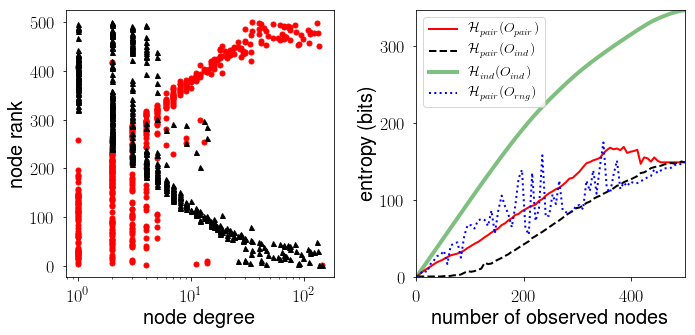

In [26]:
#Visualization

steps = len(G) / 80.0

fig = plt.figure()
fig.set_size_inches(10,5)
plt.rc('text', usetex=True)
plt.rc('font', size=18, **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel('node degree', fontsize=20)
ax1.set_ylabel('node rank', fontsize=20)


ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel('number of observed nodes', fontsize=20)
ax2.set_ylabel('entropy (bits)', fontsize=20)





x = []
y = []
z = []
for n in G:
    x.append(G.degree(n))
    y.append(mes_rank[n])
    z.append(mes_value[n])
    
    
xnew = np.linspace(min(y), max(y), num=len(y)/steps, endpoint=True)
f = interp1d(y, z, kind='cubic')
ax2.plot(xnew, f(xnew), marker='o', color='red', markeredgecolor='red', linewidth=2.0, markersize=0, alpha=1, label='$\\mathcal{H}_{pair}(O_{pair})$')
ax1.plot(x,y, marker='o', color='red', markeredgecolor='red', linewidth=0.0, markersize=5, alpha=1)
#ax2.plot(y,z, marker='o', color='red', markeredgecolor='red', linewidth=0.0, markersize=5, alpha=1, label='Maximum Entropy Sampling')




x = []
y = []
z = []
tmp = {}
for n in G:
    x.append(G.degree(n))
    y.append(ind_rank[n])
    z.append(ind_value[n])
    tmp[ind_rank[n]] = marg_entropy[n]
    
tmp_y = []
tmp_z = []
norm = 0.0
for n in range(1, len(G)+1, 1):
    tmp_y.append(n)
    norm += tmp[n]
    tmp_z.append(norm)






    
    
xnew = np.linspace(min(y), max(y), num=len(y)/steps, endpoint=True)
f = interp1d(y, z, kind='cubic')
ax2.plot(xnew, f(xnew), marker='^', color='black', markeredgecolor='black', linewidth=2.0, linestyle = 'dashed', markersize=0, alpha=1, label='$\\mathcal{H}_{pair}(O_{ind})$')
ax1.plot(x,y, marker='^', color='black', markeredgecolor='black', linewidth=0.0, markersize=5, alpha=1)
#ax2.plot(y,z, marker='o', color='red', markeredgecolor='red', linewidth=0.0, markersize=5, alpha=1, label='Maximum Entropy Sampling')


xnew = np.linspace(min(tmp_y), max(tmp_y), num=len(tmp_y)/steps, endpoint=True)
f = interp1d(tmp_y, tmp_z, kind='cubic')
ax2.plot(xnew, f(xnew), marker='^', color='green', markeredgecolor='green', linewidth=4.0, linestyle = '-', markersize=0, alpha=0.5, label='$\\mathcal{H}_{ind}(O_{ind})$')





x = []
y = []
z = []
for n in G:
    x.append(G.degree(n))
    y.append(ran_rank[n])
    z.append(ran_value[n])

xnew = np.linspace(min(y), max(y), num=len(y)/steps, endpoint=True)
f = interp1d(y, z, kind='cubic')
ax2.plot(xnew, f(xnew), marker='s', color='blue', markeredgecolor='blue', linewidth=2.0, linestyle = 'dotted', markersize=0, alpha=1, label='$\\mathcal{H}_{pair}(O_{rng})$')
#ax1.plot(x,y, marker='s', color='blue', markeredgecolor='blue', linewidth=0.0, markersize=5, alpha=1)
#ax2.plot(y,z, marker='s', color='red', markeredgecolor='red', linewidth=0.0, markersize=5, alpha=1, label='Random Sampling')




ax2.set_xlim(0, len(G))
ax2.set_ylim(0, max(tmp_z))


ax2.legend(loc=2, numpoints=1, prop={'size':14})
#ax1.locator_params(nbins=4)
ax1.set_xscale('log')
ax2.locator_params(nbins=4)



fig.tight_layout()
plt.show()